# Chapter 4: Vision Transformer (ViT) from Scratch


This chapter covers:

* The idea behind vision Transformers (ViTs) 
* Dividing an image into patches of tokens
* Training a Transformer to predict the next image token
* Classifying CIFAR-10 images using a trained ViT
* How to fine-tune a pre-trained model
* Visualizing how a trained ViT pays attention to different parts of an image


A key step in text to image generation models is to convert an image into a sequence of tokens, similar to a sequence of words in text. Based on this idea, a group of Google researchers in 2020 applied Transformer models to computer vision tasks, in a groundbreaking paper titled "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale." ViT can achieve state-of-the-art performance on various computer vision tasks. In this chapter, you'll learn to create a ViT from scratch and train it to classify images in the CIFAR-10 dataset. 

In particular, you'll learn to convert an image into an 8 by 8 grid. You'll then convert each of the 64 patches in the image into a token. Hence an image can be treated a sequence of 64 tokens. You'll then build a Transformer as a classifier. The self-attention mechanism in the Transformer allows the model to learn the relations among different patches in the image. You'll feed images in the CIFAR-10 dataset to the model to train the ViT. After training, you'll learn to use the trained model to classify unseeen images, with great accuracy. Further, you'll visualizing how a trained ViT pays attention to different parts of an image. 

# 1.    The CIFAR-10 Dataset
You’ll use the CIFAR-10 dataset to train the ViT in this chapter. CIFAR-10 is a popular dataset to train machine learning, especially computer vision, algorithms. CIFAR stands for Canadian Institute For Advanced Research. The dataset consists of 10 different classes of color images.

In this section, you'll download the dataset, split them into a train and test set, and place them in batches for training later. You'll also visualize some sample images to see what the images in this dataset look like.

The Python program in this chapter is adapted from the excellent GitHub repository of Tin Nguyen (https://github.com/tintn/vision-transformer-from-scratch). 

## 1.1 Download and Visualize CIFAR-10 Images
We'll use the datasets package in the torchvision library to download the CIFAR-10 dataset directly. We first download the training set as follows:

In [1]:
import torchvision

trainset=torchvision.datasets.CIFAR10(root=r'.', 
                          train=True, download=True)

Files already downloaded and verified


Each image in the CIFAR-10 dataset is labeled with a class number from 0 to 9. To convert these
numbers into meaningful object names, we define a list as follows: 

In [2]:
# Names of the ten types of objects
names = ['plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck']

This means an image with a label of 0 is a plane, and a lable of 1 indicates the image is a bird, and so on. 

Next, we can visualize the first 18 images in the training set as follows:

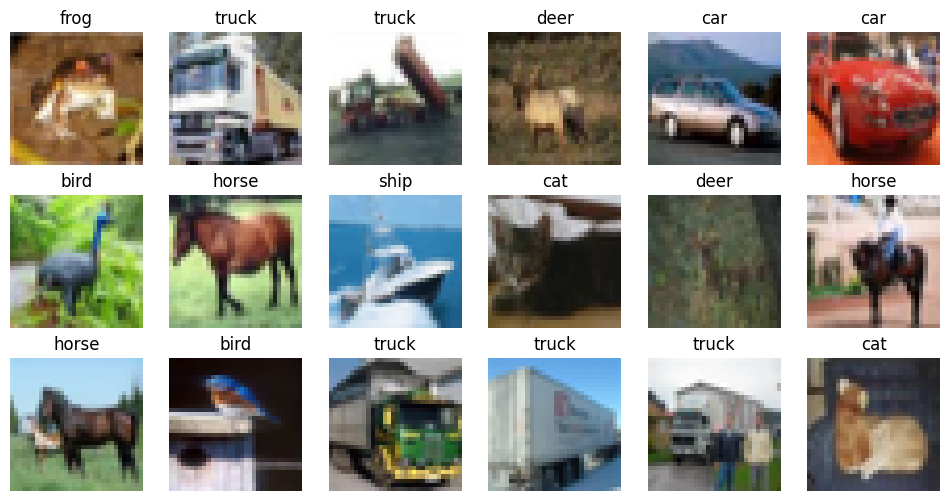

In [3]:
import matplotlib.pyplot as plt
import numpy as np 

# Create a 3 by 6 grid of pictures
plt.figure(figsize=(12,6),dpi=100)
for i in range(3):
    for j in range(6):
        plt.subplot(3, 6, 6*i+j+1)
        plt.imshow(trainset[6*i+j][0])
        plt.axis('off')
        plt.title(names[trainset[6*i+j][1]], fontsize=12)
plt.subplots_adjust(hspace=0.20)
plt.show()

We plot the 18 images in a 3 by 6 grid. The axis(′off′) option in the matplotlib library allows us to turn off the axis so you see only the pictures. We place the name of each picture as the title of the picture, so that you see it on top of each
image. For example, the top left image is a frog while the bottome right image is a cat. 

We also download the testset for out-of-the-sample testing to make sure that our trained model is not overfit. This can be done as follows:

In [4]:
testset=torchvision.datasets.CIFAR10(root=r'.', 
                          train=False, download=True)

Files already downloaded and verified


By using the train=False argument, we instruct the torchvision library to download the test subset of the CIFAR-10 dataset. 

## 1.2 Prepare datasets for training and testing
The datasets we have downloaded are Python objects. We'll transform them into PyTorch tensors so that we can feed them into the ViT later to train the model. We first transforms the training set as follows:

In [5]:
import torchvision.transforms as transforms

trainset.transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((32, 32),antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0),
                 ratio=(0.75, 1.3333333333333333), 
                 interpolation=2,antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Before the transformation, the image data are integers ranging from 0 to 255. We convert them to PyTorch float tensors with values between -1 to 1. Next, we place the training data in batches for training:

In [6]:
import torch

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                            shuffle=True)

We apply similar transformation on the test set and place them in batches as well:

In [7]:
testset.transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((32, 32),antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                        shuffle=False)

We now have the training and testing datasets ready. In the next section, we'll build a ViT to classify these images. 

# 2.	Build a Vision Transformer (ViT) from scratch
To save space, we'll define our ViT in a local module ViTutil.py. Download the file ViTutil.py from the book's GitHub repository https://github.com/markhliu/txt2img and place it in the folder /utils/ on your computer. Make sure that you place a blank file names $__init__.py$ in the folder /utils/ so that Python treats files in the folder as Python modules. 

To convert an image into a sequence, we'll first divide an image (with a size of 3 by 32 by 32, meaning three color channles with height and width of 32 pixels) into 64 different patches. Each patch has a size of (3, 4, 4). We'll use a convolutional layer to convert each patch into a vector with 48 values. These vectors are considered tokens. By doing this, we convert an images into a sequence of 64 tokens. 

ViT uses the scaled dot product attention (SDPA) mechanism to capture the relation among differnet tokens (which represent different patches in the image). In this section, we'll explain how the SDPA attention mechanism works and how we construct a ViT from scratch to classify images.

## 2.1	Divide Images into Patches
We first define a few hyperparameters that we'll use in our ViT.

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Training neural networks can be time-consuming, especially when the network is deep with many layers and is trained on large amounts of data. PyTorch provides GPU acceleration since it supports CUDA, which enables it to efficiently perform computations on GPU, significantly speeding up training and inference processes. PyTorch automatically detects if a CUDA-enabled GPU is installed on your machine and decides if GPU acceleration should be used in training. You'll see this line of code quite often in this book:

```python
device="cuda" if torch.cuda.is_available() else "cpu"
```

The above line of command automatically checks if a CUDA-enabled GPU is available for accelerated training. If yes, the program will use GPU to train the model. Otherwise, the program will default the training device to the CPU on your computer.

In [9]:
class Config:
    patch_size=4 
    hidden_size=48
    num_hidden_layers=4
    num_attention_heads=4
    intermediate_size= 4 * 48
    image_size=32
    num_classes=10 
    num_channels=3
config=Config()

We define a Config() class to contain all the hyperparameters used in our ViT. patch_size=4 each patch of image has a height and width of 4 pixels. Since our training images are 32 by 32 pixels, this means we divided each image into 8x8=64 patches. hidden_size=48 means each patch is converted into a 48-value vector. We'll use multi-head attention to capture different aspects of relations among tokens in the image, so we set num_attention_heads=4. This means we use fur attention heads intead of just one. We'll explain other hyperparameters as we go along. 

To divide an image into 64 patches, we define a PatchEmbeddings() class in the local module file ViTutil.py that you just downloaded:

```python
class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.projection = nn.Conv2d(config.num_channels,
                                    config.hidden_size, 
                                    kernel_size=config.patch_size, 
                                    stride=config.patch_size)
    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x  
```

The PatchEmbeddings() class takes a batch of images of size 3x32x32 and divides each image into 64 patches. It then uses the Conv2d layer to convert each batch into a 48-value vector.

To have a better understanding of how the PatchEmbeddings() class works, we'll create a hypothetical image and pass it through the class and print out the shape of the output, as follows:

In [10]:
from utils.ViTutil import PatchEmbeddings

patchembed=PatchEmbeddings(config)
# create a hypothetical image
img=torch.randn((1,3,32,32))
# pass a batch of one image through the class
out=patchembed(img)
# print out the shape of the output
print(out.shape)

torch.Size([1, 64, 48])


The output has a shape of (1, 64, 48): meaning there is one image in the batch; each image is divided into 64 patches. Each patch is represnted by a 48-value vector. 

## 2.2	Model the Positions of Different Patches in the Image
We have converted each image into 64 patches. To model the positions of different patches in an image, we borrow the positional encoding methods in natural language processing. Text represents a quintessential example of sequential data, which is defined as any dataset where the order of elements is critical. This structuring implies that the positioning of individual elements relative to each other holds significant meaning, often conveying essential information for understanding the data. The positions of different patches in an image are also important. Changing the poistions of two patches will lead to a different image. 

To code in the position of each patch in the image, we define an Embeddings() class in the local module as follows:

```python
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)    
        self.cls_token = nn.Parameter(torch.randn(1, 1, 
                                      config.hidden_size))  
        num_patches = (config.image_size // config.patch_size) ** 2
        self.position_embeddings = \
        nn.Parameter(torch.randn(1,num_patches+1,config.hidden_size))  
    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        return x  
```

Specifically, we first pass an image through the PatchEmbeddings() class so that the image is represented by 64 image token vectors. We then add the CLS (classification) token to the beginning of the sequence. The CLS token is also a 48-value vector and it will be used in the classification layer in our ViT to classify the image. The CLS token is not associated with any specific part of the image but is used to aggregate information across the entire image for the purpose of classification. This approach allows ViT to leverage the strengths of Transformer models for image analysis tasks.

Therefore, the image is now represented by 64+1=65 token vectors. To model the positions of these tokens, we create a positional encoding for the sequence, with a size of 65x48, the same as the token embeddings of the image. That is, the first poistion is represted by a 48-value vector, and so is the second position, and so on. These 65 positional vectors are learned from the training data. Finally, the positional encoding is added to the token embedding and used as the output of the above Embeddings() class. 

We again use a hypothetical image and pass it through the Embeddings() class to show how positional encoding works:

In [11]:
from utils.ViTutil import Embeddings

embed=Embeddings(config)
# create a hypothetical image
img=torch.randn((1,3,32,32))
# pass a batch of one image through the class
out=embed(img)
# the shapes of the output
print(out.shape)
# the shapes of the positional encoding
print(embed.position_embeddings.shape)

torch.Size([1, 65, 48])
torch.Size([1, 65, 48])


Both the output from the Embeddings() class and the positional encoding has a shape of (1, 64, 48).

## 2.3	The Multi-Head Self-Attention Mechanism
The scaled dot product attention (SDPA) uses query, key, and value to calculate the relationships among elements in a sequence. It assigns scores to show how an element in a sequence is related to all other elements. Furthermore, instead of using one set of query, key, and value vectors, the Transformer model uses a concept called multi-head attention. In our example, the embedding dimension is 48 (meaning each token is represented by a 48-value vector) and we split the 48-dimensional query, key, and value vectors into 4 heads, and each head has a set of query, key, and value vectors with dimensions of 12 (because 48/4=12). Each head pays attention to different parts or aspects of the input, enabling the model to capture a broader range of information and form a more detailed and contextual understanding of the image.

To implement this, we define the AttentionHead() class in the local module ViTutil.py as follows:

```python
class AttentionHead(nn.Module):
    def __init__(self, hidden_size, attention_head_size, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)   
    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(\
                self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs) 
```

The AttentionHead() class takes a sequence x as the input. It passes x through three linear layers to obtain query, key, and value vectors. The corresponding weights for the three linear layers are WQ, WK, and WV, each having a dimension of 12 by 12. These weights are learned from data during the training phase. Thus, we calculate query Q, key K, and value V as Q=X@WQ, K=X@QK, and V=X@WV. 

We assess the similarities between the  query and key vectors using the SDPA approach. SDPA involves calculating the dot product of the query (Q) and key (K) vectors. A high dot product indicates a strong similarity between the two vectors, and vice versa. The dot product is scaled by the square root of dk (the dimension of the key vector K, which in our case is 12 in each head) to obtain the scaled attention scores. The next step is to apply the softmax function to these attention scores, converting them into attention weights. This ensures that the total attention a token gives to all tokens in the sequence sums to 100%. The final attention is then calculated as the dot product of these attention weights and the value vector V. 

The MultiHeadAttention() class in the local module ViTutil.py calculates multihead attention as follows:

```python
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = \
        self.hidden_size // self.num_attention_heads
        self.all_head_size = \
        self.num_attention_heads * self.attention_head_size
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size)
            self.heads.append(head)
        self.output_projection = nn.Linear(self.all_head_size,\
                                           self.hidden_size) 
    def forward(self, x, output_attentions=False):
        attention_outputs = [head(x) for head in self.heads]
        attention_output = torch.cat([attention_output for attention_output,
                                      _ in attention_outputs], dim=-1)
        attention_output = self.output_projection(attention_output)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, 
                           attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)   
```        

The MultiHeadAttention() class first create multiple heads. It then passes the input sequence x through each head and calculate the attention by using the AttentionHed() class we defined earlier. It then concatenate the attention vectors in the four heads into one large attention vector.  

## 2.4	Build An Encoder-Only Transformer
To create an encoder-only Transformer, we stack N=4 identical encoder layers together to increase representation capacity and enable hierarchical feature extraction. Each encoder layer is composed of two distinct sublayers: one is a multi-head self-attention layer, as defined in the MultiHeadAttention() class, and the other is a straightforward, position-wise, fully connected feed-forward network, as defined in the MLP() class in the local module ViTutil.py, as follows:

```python
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config.hidden_size,
                                 config.intermediate_size)
        self.activation = GELU()
        self.dense_2 = nn.Linear(config.intermediate_size,
                                 config.hidden_size)
    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        return x 
```

The MLP() class is defined with two key parameters: intermediate_size, the dimensionality of the feed-forward layer, and hidden_size, representing the model’s dimension size. Typically, intermediate_size is chosen to be four times the size of hidden_size. In our example, hidden_size is 48 and we therefore set intermediate_size to 4x48=192. This practice is a standard approach in Transformer architectures. It enhances the network's ability to capture and learn intricate features in the training dataset.

Each encoder block is created by the following Block() class in the local module:

```python
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config.hidden_size)
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config.hidden_size)
    def forward(self, x, output_attentions=False):
        attention_output, attention_probs = \
        self.attention(self.layernorm_1(x),
                       output_attentions=output_attentions)
        x = x + attention_output
        mlp_output = self.mlp(self.layernorm_2(x))
        x = x + mlp_output  
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)
```

Each encoder block is composed of two distinct sublayers: a multi-head self-attention layer and a straightforward, position-wise, fully connected feed-forward network. Additionally, both of these sublayers incorporate layer normalization and residual connections. A residual connection involves passing the input through a sequence of transformations and then adding the input back to these transformations' output. The method of residual connection is employed to combat the issue of vanishing gradients, which is a common challenge in very deep networks. Layer normalization standardizes the observations in a layer to have a zero mean and a unit standard deviation. 

We stack four such encoder blocks together to form an encoder-only Transformer, as illustrated by the Encoder() class in the local module:

```python
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(config.num_hidden_layers):
            block = Block(config)
            self.blocks.append(block)
    def forward(self, x, output_attentions=False):
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, 
               output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)
```

The are four encoder blocks in the encoder-only Transformer. The output from the first block is used as the input to the second block. The output from the second block is used as the input to the third block, and so on.

## 2.5	Use the Vision Transformer to Create A Classifier 
Typically, a Transformer can be used for various downstream tasks such as text generation, classification, or summarization. In our setting, the goal is to use the vision Transformer to classify images in the CIFAR-10 dataset. We therefore create a classifier based on the vision Transformer we just built through the ViTForClassification() class in the local module:

```python
class ViTForClassfication(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config.image_size
        self.hidden_size = config.hidden_size
        self.num_classes = config.num_classes
        self.embedding = Embeddings(config)
        self.encoder = Encoder(config)
        self.classifier = nn.Linear(self.hidden_size,
                                    self.num_classes)
        self.apply(self._init_weights)
    def forward(self, x, output_attentions=False):
        embedding_output = self.embedding(x)
        encoder_output, all_attentions = self.encoder(\
          embedding_output,output_attentions=output_attentions)
        logits = self.classifier(encoder_output[:, 0, :])
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,std=0.02,).to(module.position_embeddings.dtype)
            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,std=0.02,).to(module.cls_token.dtype)
```            

The ViTForClassification() class takes a batch of images as input and outputs the logits over the ten classes of objects. Later we'll apply the softmax function on these logits to obtain the probability distributions of the images over the ten classes.

To achieve this, the ViTForClassification() class first passes the images through the Embeddings() class defined earlier to obtain the input embedding, which is the sum of token embedding and positional encoding. The input embeddings are then passed through the encoder-only Transformer. Instead of using all outputs from the Transformer, we use only the output associated with the CLS token. As we explained earlier, the CLS token is not associated with any specific part of the image but is used to aggregate information across the entire image for the purpose of classification. Finally, we initialize model weights in a narrow range to stablize training. 

# 3	Train the Vision Transformer to Classify Images
Our constructed classifier can be trained to predict which class an image belongs to in the CIFAR-10 dataset. In this section, we will detail the process of selecting an appropriate loss function and optimizer. We will train the vision Transformer using batches of data prepared earlier in this chapter. After the model is trained, we will use it to classify images in the next section. 

## 3.1 Choose the Optimizer and the Loss Function
We first instantiate the ViTForClassfication() class from the local module to create an image classifier, as follows:

In [12]:
from utils.ViTutil import ViTForClassfication

model = ViTForClassfication(config).to(device)

We'll use the AdamW optimizer, a variant of the Adam optimizer that we have been widely used in machine learning. The AdamW optimizer, first proposed by Ilya Loshchilov and Frank Hutter, decouples weight decay (a form of regularization) from the optimization steps (Ilya Loshchilov and Frank Hutter, 2017, Decoupled Weight Decay Regularization. https://arxiv.org/abs/1711.05101). Instead of applying weight decay directly to the gradients, AdamW applies weight decay directly to the parameters (weights) after the optimization step. This modification helps achieve better generalization performance by preventing the decay rate from being adapted along with the learning rates. Interested readers can learn more about the AdamW optimizer in the original paper by Loshchilov and Hutter.

In [13]:
from torch import nn, optim

optimizer = optim.AdamW(model.parameters(), 
                lr=0.01, weight_decay=1e-2)

Since this is a multi-category classification problem, we'll use the categorical cross-entropy loss function, as follows:

In [14]:
loss_fn = nn.CrossEntropyLoss()

We'll use PyTorch’s automatic mixed precision package torch.cuda.amp to speed up training. The default data type in PyTorch tensors is float32, a 32-bit floating-point number, which takes up twice as much memory as a 16-bit floating number, float16. Operations on the former are slower than those on the latter. There is a trade-off between precision and computational costs. Which data type to use depends on the task at hand. torch.cuda.amp provides an automatic mixed precision, where some operations use float32 and others float16. Mixed precision tries to match each operation to its appropriate data type to speed up training.
We therefore instantiate a GradScaler() class as follows: 

In [15]:
scaler = torch.cuda.amp.GradScaler()

The use of PyTorch’s automatic mixed precision package reduces the training time by more than 50%.

## 3.2 Train the Classifier for Image Classification
We train the model for ten epochs, as follows:

In [16]:
from tqdm import tqdm

train_losses, test_losses, accuracies = [], [], []

for i in range(10):
    model.train()
    train_loss = 0
    pbar=tqdm(trainloader)
    for batch in pbar:
        batch = [t.to(device) for t in batch]
        images, labels = batch
        with torch.cuda.amp.autocast():
            loss = loss_fn(model(images)[0], labels)
        optimizer.zero_grad() 
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()        
        train_loss+=loss.item()*len(images)/len(trainloader.dataset)
        pbar.set_description(f"loss: {loss.item():.4f}")
    model.eval()
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for batch in testloader:
            batch = [t.to(device) for t in batch]
            images, labels = batch
            logits, _ = model(images)
            loss = loss_fn(logits, labels)
            test_loss += loss.item() * len(images)/ len(testloader.dataset)
            predictions = torch.argmax(logits, dim=1)
            acc += torch.sum(predictions == \
                             labels).item()/ len(testloader.dataset)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(acc)
    print(f'''Epoch: {i+1}, Train loss: {train_loss:.4f}, 
    Test loss: {test_loss:.4f}, Accuracy: {acc:.4f}''')

loss: 1.8167: 100%|████████████████████████████████████████████████████████████████| 1563/1563 [01:27<00:00, 17.88it/s]


Epoch: 1, Train loss: 1.8239, 
    Test loss: 1.6075, Accuracy: 0.4063


loss: 1.3388: 100%|████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.20it/s]


Epoch: 2, Train loss: 1.5387, 
    Test loss: 1.4995, Accuracy: 0.4607


loss: 1.3220: 100%|████████████████████████████████████████████████████████████████| 1563/1563 [01:26<00:00, 18.10it/s]


Epoch: 3, Train loss: 1.4607, 
    Test loss: 1.5764, Accuracy: 0.4411


loss: 1.1545: 100%|████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.28it/s]


Epoch: 4, Train loss: 1.4079, 
    Test loss: 1.4316, Accuracy: 0.4906


loss: 1.4482: 100%|████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.34it/s]


Epoch: 5, Train loss: 1.3719, 
    Test loss: 1.3094, Accuracy: 0.5337


loss: 1.2894: 100%|████████████████████████████████████████████████████████████████| 1563/1563 [01:26<00:00, 17.98it/s]


Epoch: 6, Train loss: 1.3345, 
    Test loss: 1.2898, Accuracy: 0.5439


loss: 1.3791: 100%|████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.38it/s]


Epoch: 7, Train loss: 1.3095, 
    Test loss: 1.2571, Accuracy: 0.5475


loss: 1.1609: 100%|████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.23it/s]


Epoch: 8, Train loss: 1.2835, 
    Test loss: 1.2755, Accuracy: 0.5407


loss: 1.4013: 100%|████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.21it/s]


Epoch: 9, Train loss: 1.2623, 
    Test loss: 1.2328, Accuracy: 0.5489


loss: 1.3392: 100%|████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.34it/s]


Epoch: 10, Train loss: 1.2461, 
    Test loss: 1.2476, Accuracy: 0.5601


We save the trained weights as follows:

In [17]:
import os
os.makedirs("files", exist_ok=True)
torch.save(model.state_dict(),"files/ViT.pth")

We can plot the losses and accuracies in the train and test sets during the training process:

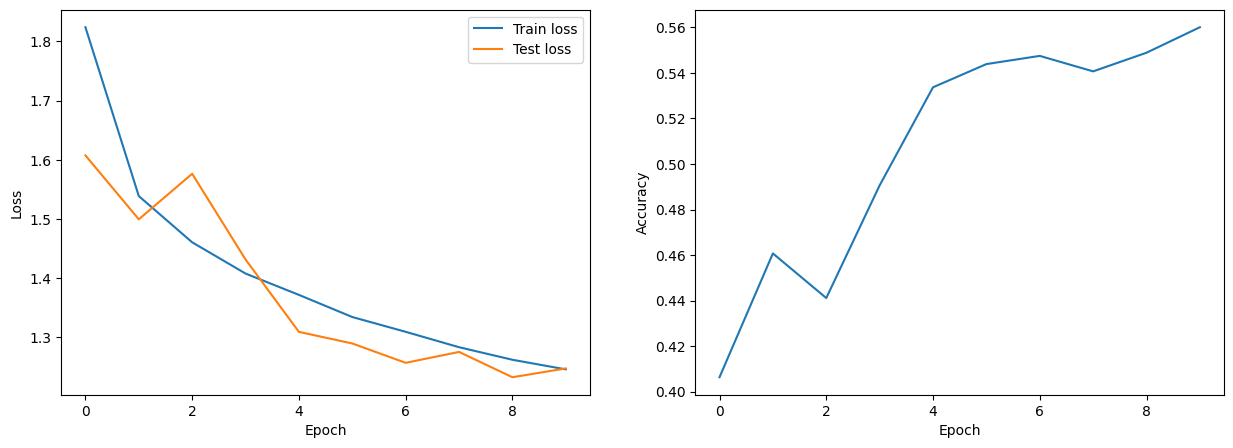

In [18]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.show()

# Classify Images Using the trained Vision Transformer
We can visualize the predictions by using the trained vision Transformer. More importantly, 

Files already downloaded and verified


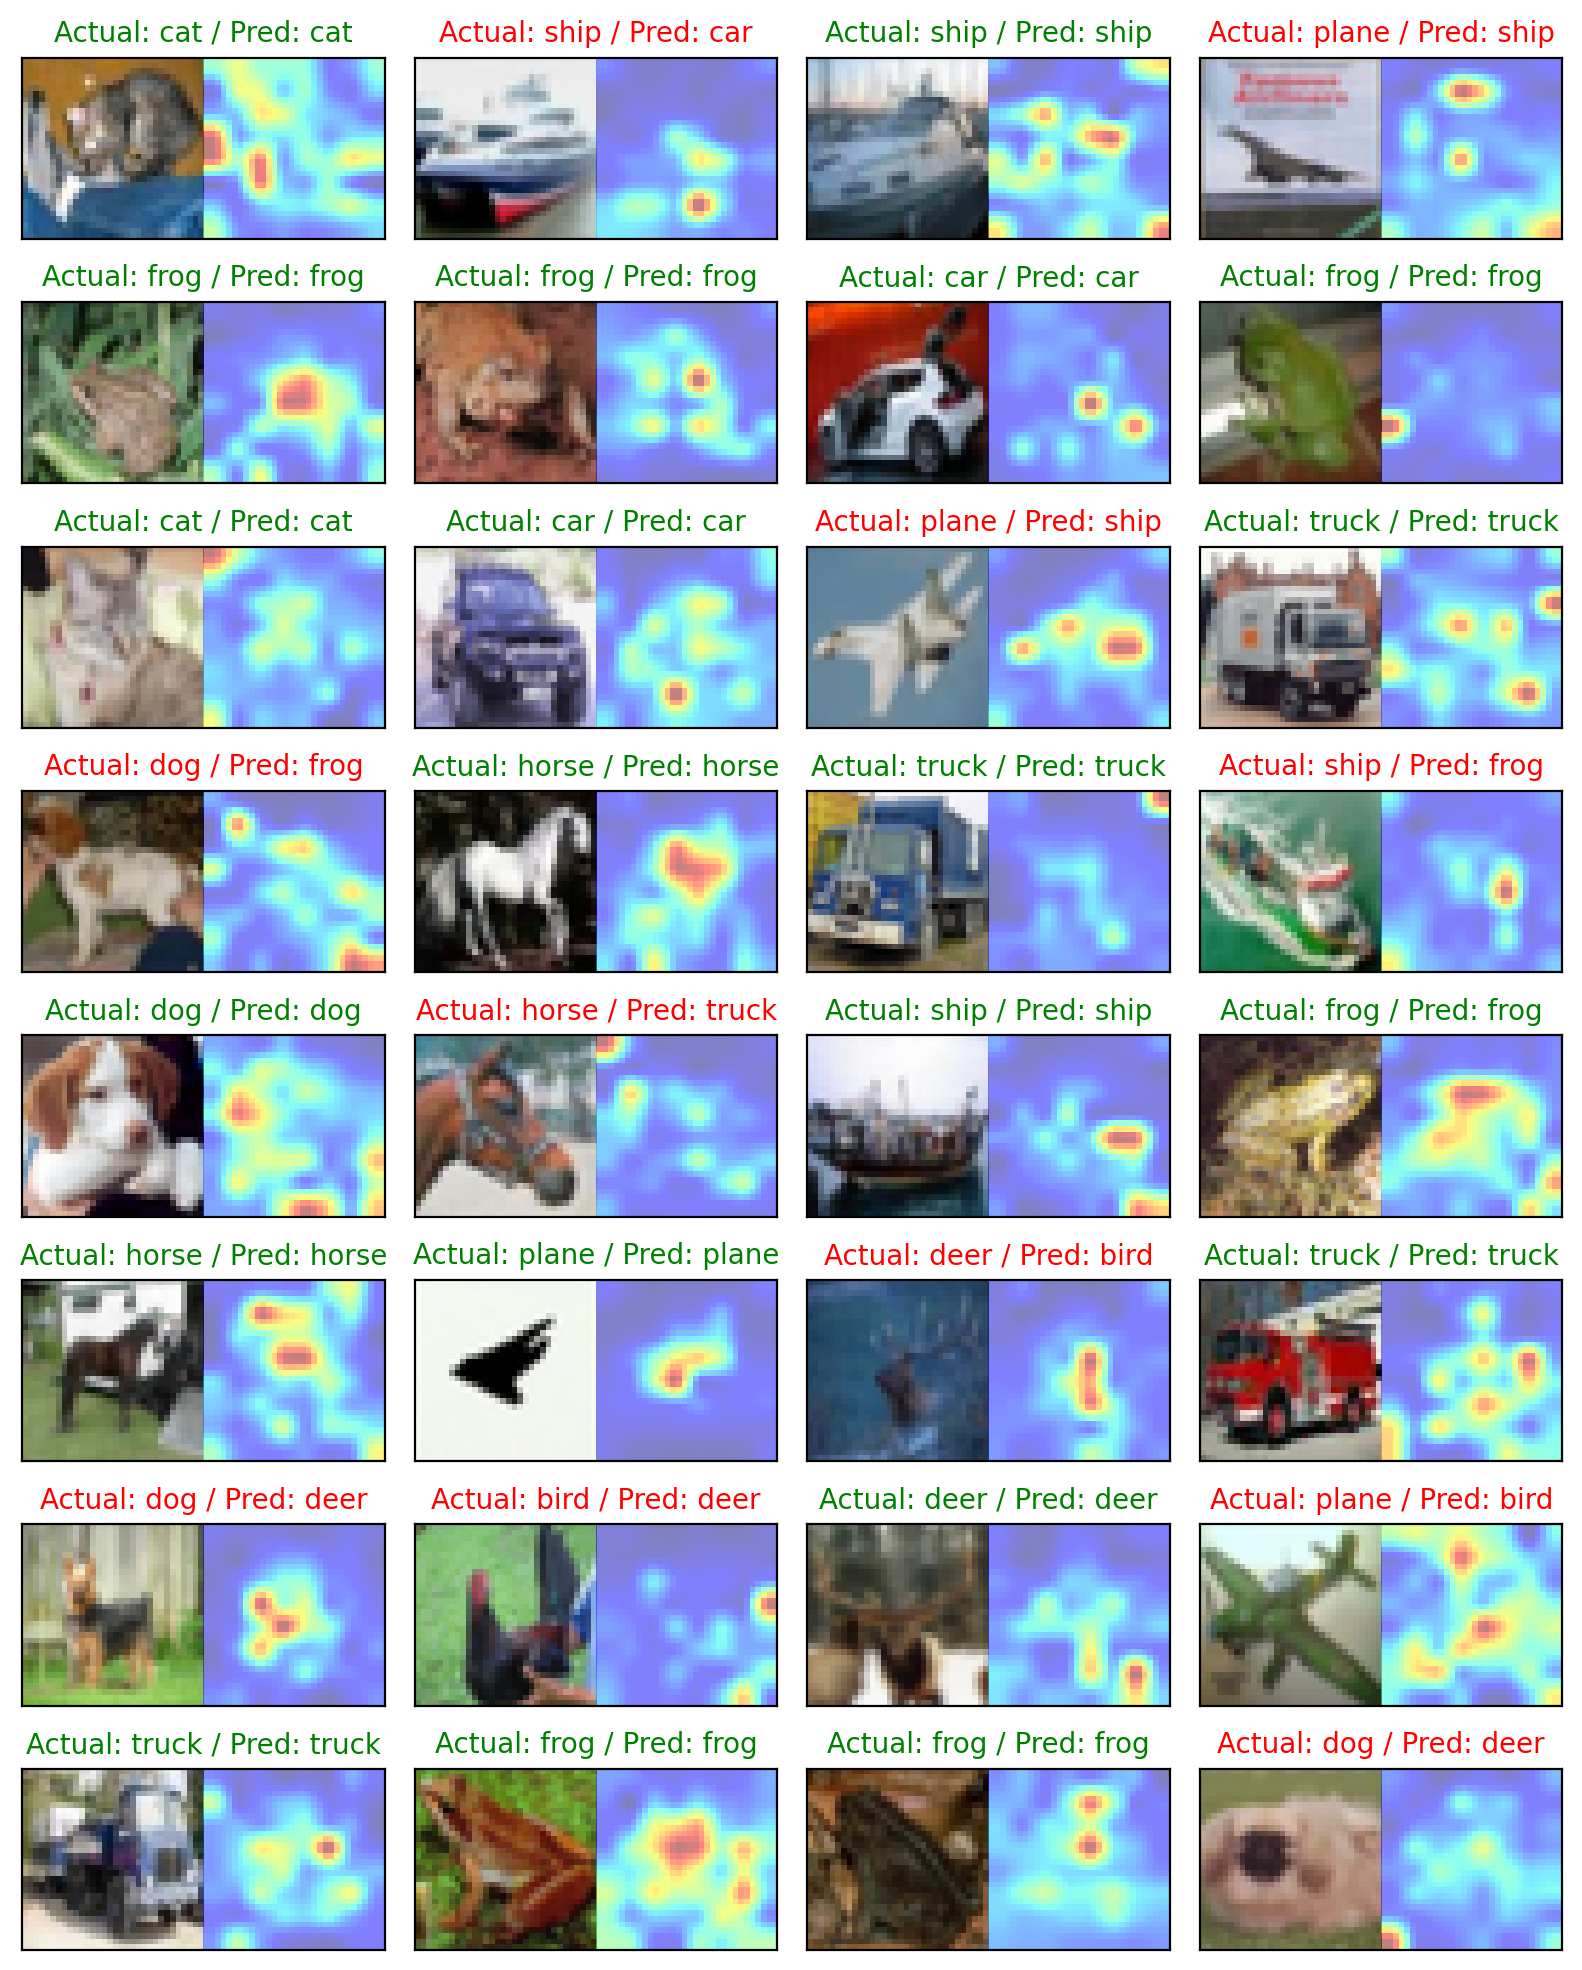

In [19]:
import math
import torch.nn.functional as F  

model.load_state_dict(torch.load('files/ViT.pth'))
model.eval()
with torch.no_grad():
    batch=next(iter(testloader))
    batch = [t.to(device) for t in batch]
    images, labels = batch
    logits, attention_maps = model(images, output_attentions=True)
    predictions = torch.argmax(logits, dim=1)
    attention_maps = torch.cat(attention_maps, dim=1)
    attention_maps = attention_maps[:, :, 0, 1:]
    attention_maps = attention_maps.mean(dim=1)
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32),
                       mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    fig = plt.figure(figsize=(8, 10),dpi=200)
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))],
                          axis=1)
    for i in range(32):
        ax = fig.add_subplot(8,4, i+1, xticks=[], yticks=[])
        img = np.concatenate((images[i].cpu(), images[i].cpu()),
                             axis=1)
        ax.imshow(img.transpose(1,2,0)/2+0.5)
        extended_attention_map = np.concatenate((np.zeros((32, 32)), 
                                         attention_maps[i].cpu()),
                                                axis=1)
        extended_attention_map = np.ma.masked_where(mask==1,
                                        extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        gt = names[labels[i]]
        pred = names[predictions[i]]    
        ax.set_title(f"Actual: {gt} / Pred: {pred}", 
                     color=("green" if gt==pred else "red"),
                    fontsize=10)
    plt.tight_layout()
    plt.show()        